<a href="https://colab.research.google.com/github/CoderAPS/HuBMAP/blob/main/HuBMAP_create_mask_20230601.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# imports libraries
import glob
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
from PIL import Image
from scipy.ndimage import label
from tqdm.notebook import tqdm_notebook

%matplotlib inline

In [2]:
# Check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
!ls /gdrive/MyDrive/DATA/HuBMAP

annotation_count.csv  polygons.jsonl	     test	    train
masks		      sample_submission.csv  tile_meta.csv  wsi_meta.csv


In [ ]:
# Create folder for the storing the created mask
# mask_file_path = '/gdrive/MyDrive/DATA/HuBMAP/masks'
# os.makedirs(mask_file_path)

In [5]:
# Obtain list of all images in train folder
file_path = '/gdrive/MyDrive/DATA/HuBMAP/'
train = glob.glob(file_path + 'train/*')

In [6]:
train[:6]

['/gdrive/MyDrive/DATA/HuBMAP/train/da693ca2093c.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/train/daf9eb07acd4.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/train/db047e105270.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/train/da5cca9855f5.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/train/dbb355ee6c9a.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/train/dbbbdfb26928.tif']

In [7]:
# Create a dictionary to hold the annotations for each image
annotations = {}

# Open the annotations file
with open(file_path + '/polygons.jsonl', 'r') as f:
    # For each line in the file
    for line in f:
        # Parse the line as JSON
        annotation = json.loads(line)

        # Get the image ID and the list of annotations for this image
        image_id = annotation['id']
        image_annotations = annotation['annotations']

        # Store the annotations in the dictionary
        annotations[image_id] = image_annotations

In [11]:
list(annotations.keys())[:4]

['0006ff2aa7cd', '00168d1b7522', '0033bbc76b6b', '003504460b3a']

In [12]:
image_map = {path.split('/')[-1].split('.')[0]: path for path in train}

In [ ]:
list(image_map.values())[:3]

['/gdrive/MyDrive/DATA/HuBMAP/train/da693ca2093c.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/train/daf9eb07acd4.tif',
 '/gdrive/MyDrive/DATA/HuBMAP/train/db047e105270.tif']

In [13]:
# Convert image color to RGB and resize images to 512 X 512
def preprocess_image(image):
    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image
    image_resized = cv2.resize(image_rgb, (512 , 512))

    return image_resized


  0%|          | 0/1633 [00:00<?, ?it/s]

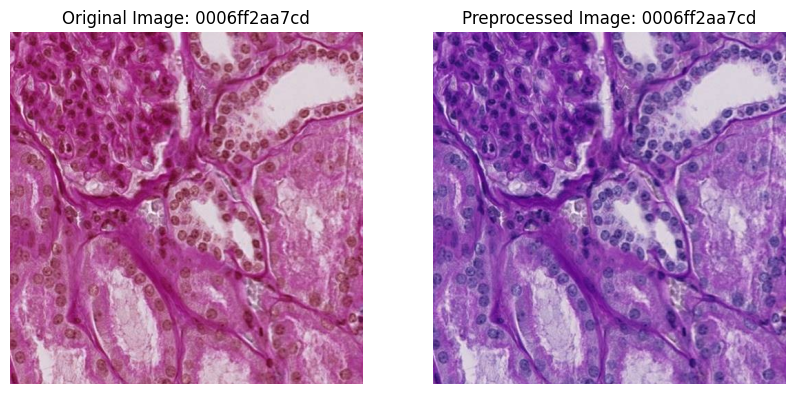

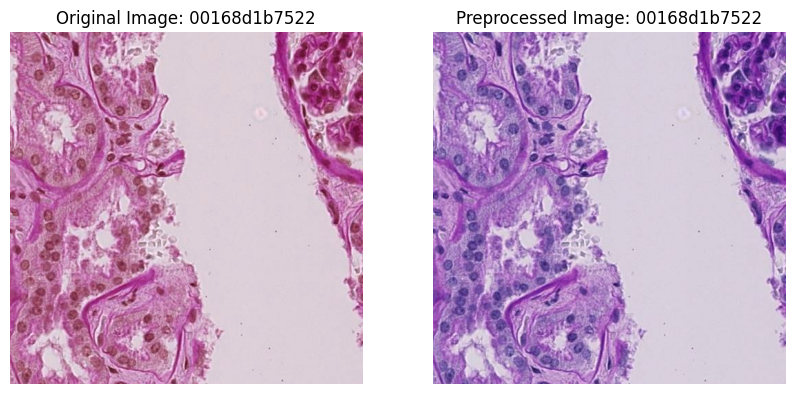

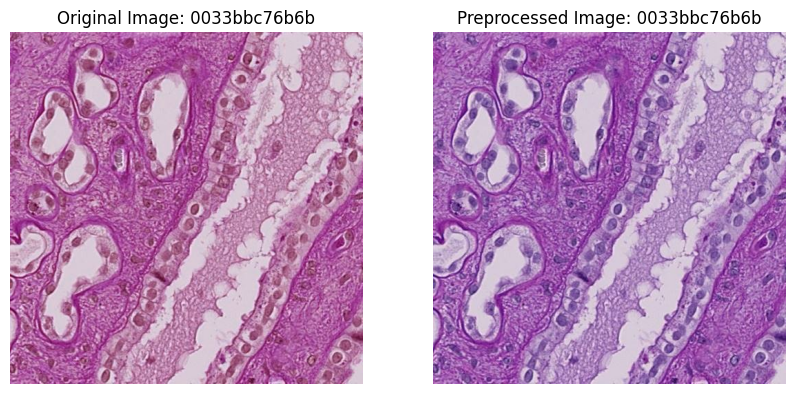

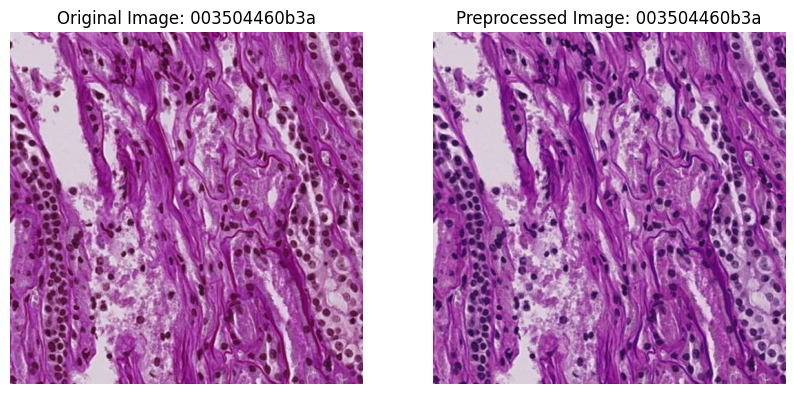

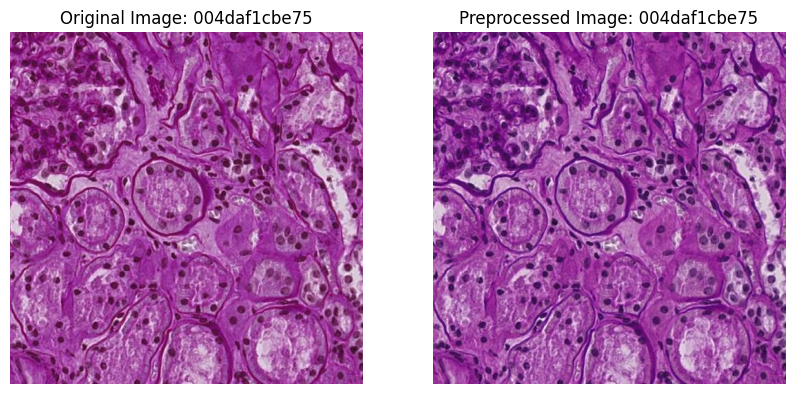

In [14]:
# Load images, preprocess and display the first five original and preprocessed
# images
images_with_annotations = {}
for i, image_id in tqdm_notebook(enumerate(list(annotations.keys())),total=len(annotations)):
    # Open the image file
    if image_id in image_map:
        image = cv2.imread(image_map[image_id])
        preprocessed_image = preprocess_image(image.copy())
        
        images_with_annotations[image_id] = preprocessed_image

         # For the first 5 images, display the original and preprocessed image side by side
        if i < 5:
             plt.figure(figsize=(10, 5))

             plt.subplot(1, 2, 1)
             plt.imshow(image)
             plt.title("Original Image: " + image_id)
             plt.axis('off')

             plt.subplot(1, 2, 2)
             plt.imshow(preprocessed_image)
             plt.title("Preprocessed Image: " + image_id)
             plt.axis('off')

             plt.show()

In [17]:
# Create binary masks and display results for first 5
def display_images_masks_overlays(image, masks, image_id):
    overlay = image.copy()
    # colors for blood vessels, glomerulus and unsure respectively
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]  

    # Initialize dictionary to hold annotation counts
    annotation_counts = {}
    
    for idx, (annotation_type, mask) in enumerate(masks[image_id].items(), 0):
        # Count the number of distinct areas in the mask
        labeled, num_areas = label(mask)
        annotation_counts[annotation_type] = num_areas

        # update overlay
        overlay[mask > 0] = colors[idx]

    # print annotation counts
    print(f"Annotation counts for image {image_id}: {annotation_counts}")

    # prepare for subplot
    plt.figure(figsize=(25,5))

    # plot the original image
    plt.subplot(1,5,1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    
    for idx, (annotation_type, mask) in enumerate(masks[image_id].items(), 2):
        # plot the binary masks
        plt.subplot(1,5,idx)
        plt.imshow(mask, cmap='gray')
        plt.title(f'{annotation_type} mask')
        plt.axis('off')

    # plot the overlay
    plt.subplot(1,5,5)
    plt.imshow(image)  # Use RGB image
    plt.imshow(overlay, alpha=0.4)  # change alpha to adjust transparency
    plt.title('Overlay')
    plt.axis('off')
    plt.show()

  0%|          | 0/1633 [00:00<?, ?it/s]

Annotation counts for image 0006ff2aa7cd: {'blood_vessel': 8, 'glomerulus': 1, 'unsure': 0}


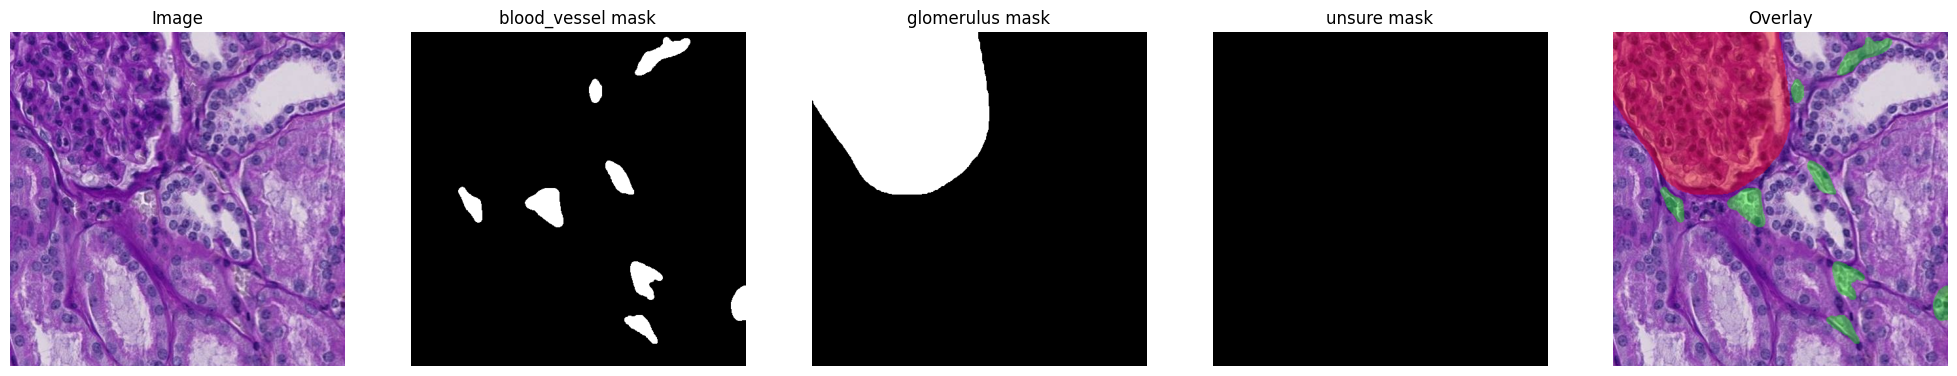

Annotation counts for image 00168d1b7522: {'blood_vessel': 1, 'glomerulus': 1, 'unsure': 0}


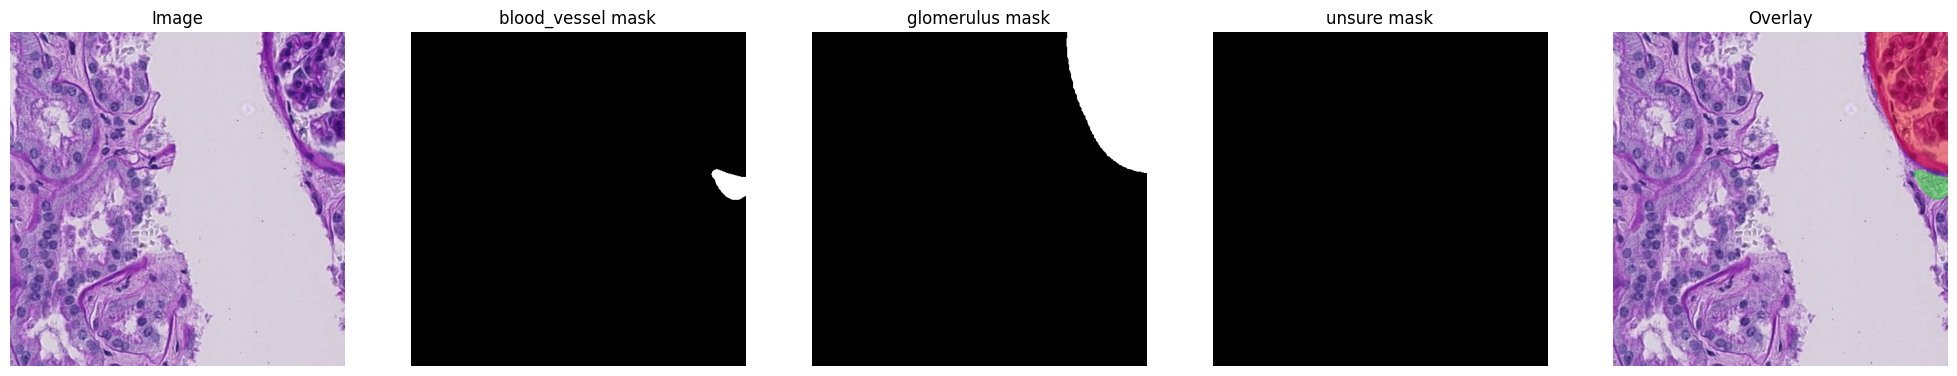

Annotation counts for image 0033bbc76b6b: {'blood_vessel': 3, 'glomerulus': 0, 'unsure': 1}


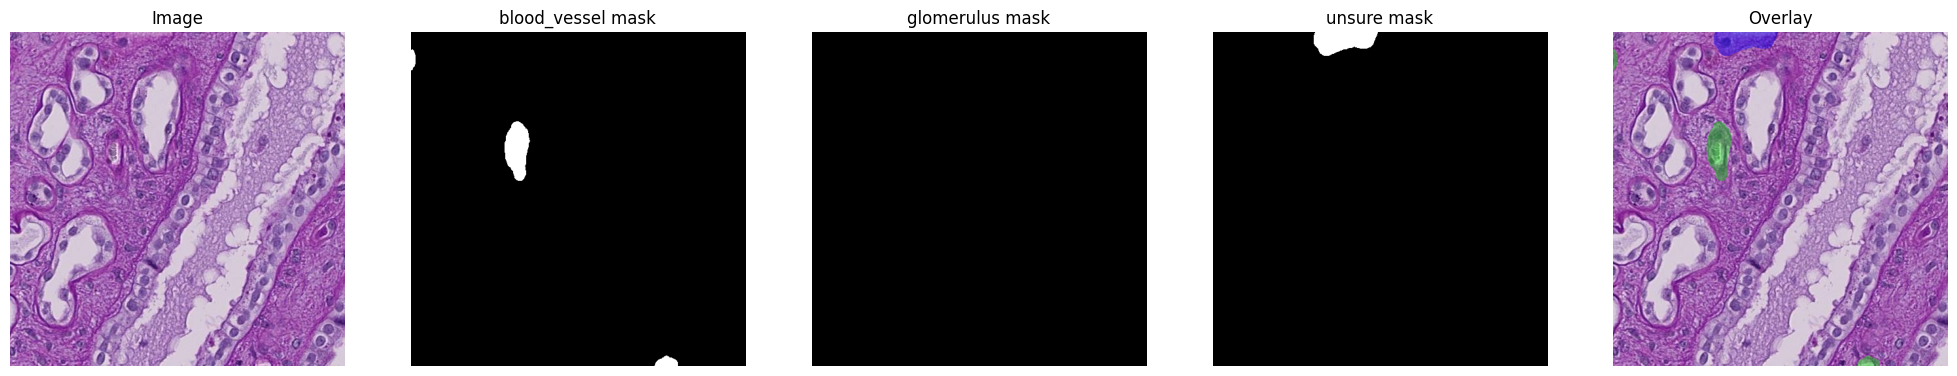

Annotation counts for image 003504460b3a: {'blood_vessel': 7, 'glomerulus': 0, 'unsure': 0}


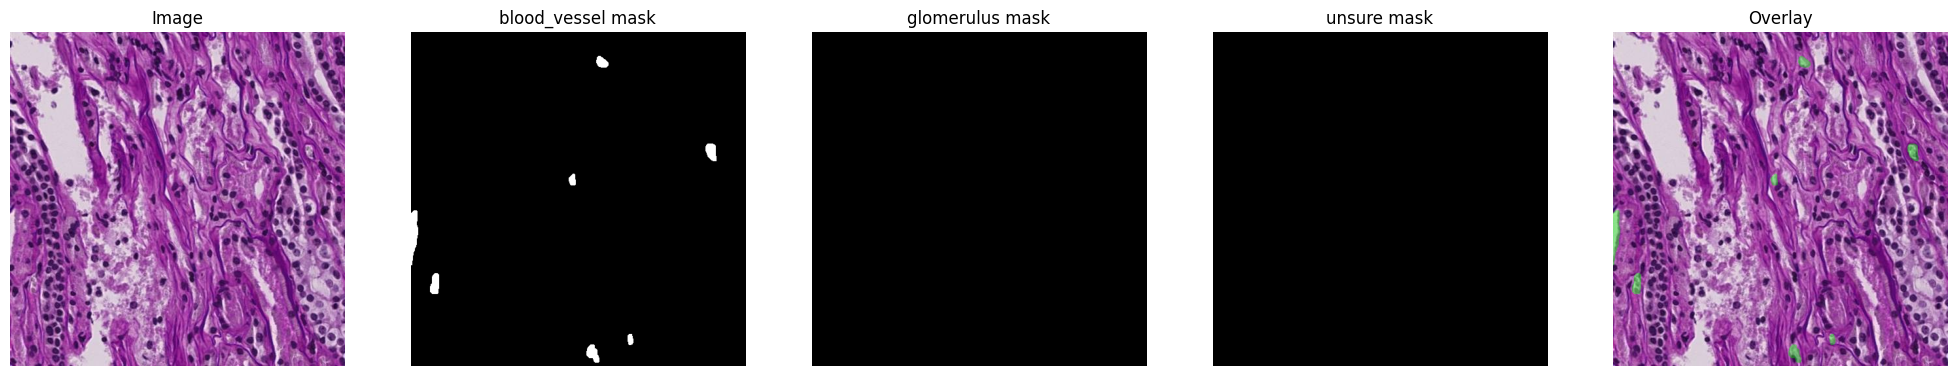

Annotation counts for image 004daf1cbe75: {'blood_vessel': 9, 'glomerulus': 1, 'unsure': 0}


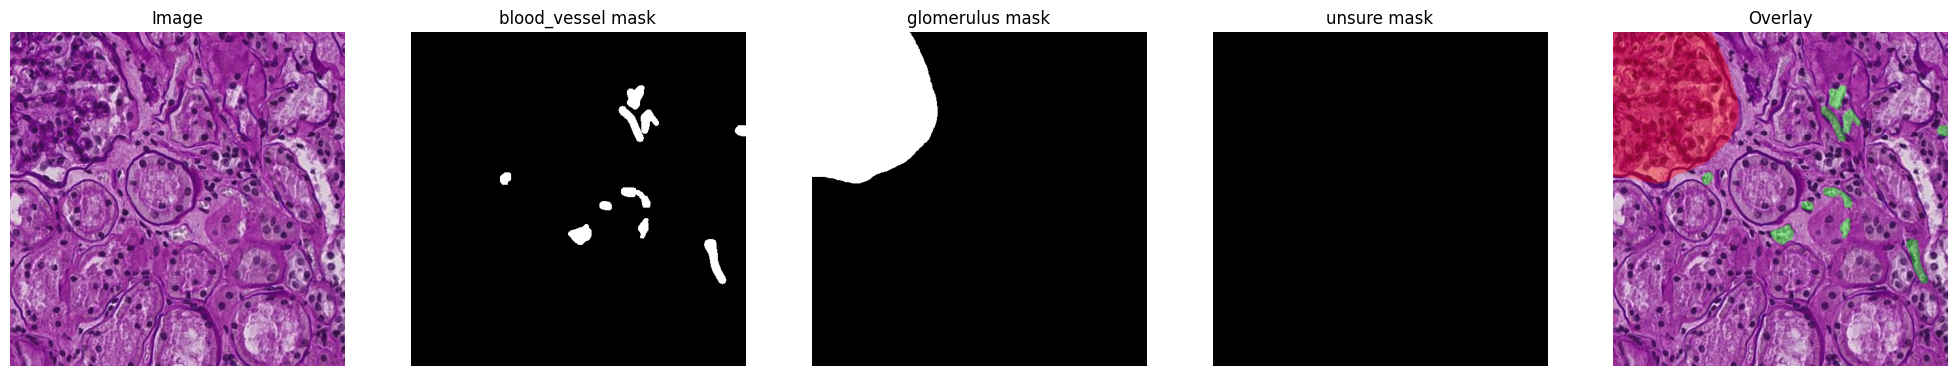

In [19]:

line_1a = None
line_1b = None
binary_masks = {}
annotation_types = ['blood_vessel', 'glomerulus', 'unsure']
for image_id in tqdm_notebook(annotations.keys(),total=len(annotations)):
    if image_id in images_with_annotations:
        polygons = annotations[image_id]
        # Load the preprocessed image
        image = images_with_annotations[image_id]

        # Create an empty mask of the same size as the image
        binary_masks[image_id] = {annotation_type: np.zeros(image.shape[:2], 
                    dtype=np.uint8) for annotation_type in annotation_types}

        # For each polygon
        for polygon in polygons:
            annotation_type = polygon['type']
            lines = np.array(polygon['coordinates'])
            line_1a = lines
            lines = lines.reshape(-1, 1, 2)
            # Draw the polygon on the mask
            cv2.fillPoly(binary_masks[image_id][annotation_type], [lines], 255)
            line_1b = lines

        # Display the image and its masks if it's one of the first 5 images
        if len(binary_masks) <= 5:
            display_images_masks_overlays(image, binary_masks, image_id)

In [30]:
line_1b.shape

(59, 1, 2)

In [ ]:
list(binary_masks.keys())[:3]

['0006ff2aa7cd', '00168d1b7522', '0033bbc76b6b']

In [31]:
os.mkdir('/gdrive/MyDrive/DATA/HuBMAP/temp_mask/')

In [32]:
!ls /gdrive/MyDrive/DATA/HuBMAP/

annotation_count.csv  sample_submission.csv  tile_meta.csv
masks		      temp_mask		     train
polygons.jsonl	      test		     wsi_meta.csv


In [52]:
mask_file_path = '/gdrive/MyDrive/DATA/HuBMAP/masks/'

In [39]:
# version_1
# make final mask with all four classifications
idx = 0
for mask_id in tqdm_notebook(list(binary_masks.keys()),total=10):
  final_mask = np.zeros((len(binary_masks[mask_id]['blood_vessel']),
               len(binary_masks[mask_id]['blood_vessel'])),dtype=np.uint8)
  
  for row in range(final_mask.shape[0]):
    for col in range(final_mask.shape[1]):
        if binary_masks[mask_id]['blood_vessel'][row][col] == 255:
            final_mask[row][col] = 1.
        elif binary_masks[mask_id]['glomerulus'][row][col] == 255:
                final_mask[row][col] = 2.
        elif binary_masks[mask_id]['unsure'][row][col] == 255:
                final_mask[row][col] = 3.
        else:
                final_mask[row][col] = 0.


    palette = [128,128,128,     # 0=gray
            255,0,0,          # 1= red
            255,255,0,        # 2=yellow
            0,0,255]          # 3=blue
  
  # Pad with zeroes to 768 values, i.e. 256 RGB colours
  palette = palette + [0]*(768-len(palette))

  # Convert Numpy array to palette image
  mask_pi = Image.fromarray(final_mask,'P')

  # Put the palette in
  mask_pi.putpalette(palette)
  
  mask_pi.save('/gdrive/MyDrive/DATA/HuBMAP/temp_mask/'+ mask_id + '_mask.tif')
  idx += 1
  if idx == 10: break
  #cv2.imwrite(mask_file_path + mask_id + '_mask.tif',final_mask)

  0%|          | 0/10 [00:00<?, ?it/s]

In [95]:
# version_2
# make final mask with all four classifications

for mask_id in tqdm_notebook(list(binary_masks.keys()),total=len(binary_masks)):
  
  blood_vessel = binary_masks[mask_id]['blood_vessel']
  glomerulus = binary_masks[mask_id]['glomerulus']
  unsure = binary_masks[mask_id]['unsure']
  
  # Reassign distinct pixel values for blood, glomerulus and unsure
  # For background the value of zero is assigned
  blood_vessel[blood_vessel == 255] = 1
  glomerulus[glomerulus == 255] = 2
  unsure[unsure == 255] = 3

  merged_mask = blood_vessel + glomerulus + unsure

  # Color assign each class (background, blood vessel, glomerulus and unsure)
  # a distinct color to be displayed with when viewd
  palette = [128,128,128,     # 0=gray
            255,0,0,          # 1= red
            255,255,0,        # 2=yellow
            0,0,255]          # 3=blue
  
  # Pad with zeroes to 768 values, i.e. 256 RGB colours
  palette = palette + [0]*(768-len(palette))

  # Convert Numpy array to palette image
  mask_pi = Image.fromarray(merged_mask,'P')

  # Put the palette in
  mask_pi.putpalette(palette)
  
  # Save mask to specified file
  mask_pi.save('/gdrive/MyDrive/DATA/HuBMAP/masks_4d/'+ mask_id + '_mask.tif')

  0%|          | 0/1633 [00:00<?, ?it/s]

In [120]:
#!ls /gdrive/MyDrive/DATA/HuBMAP/masks_4d

(512, 512, 4)

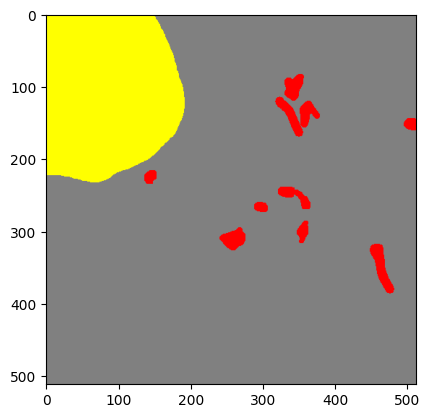

In [47]:
img = plt.imread('/gdrive/MyDrive/DATA/HuBMAP/temp_mask/004daf1cbe75_mask.tif')
plt.imshow(img)
img.shape

In [99]:
!ls /gdrive/MyDrive/DATA/HuBMAP/

annotation_count.csv  polygons.jsonl	     test	    wsi_meta.csv
masks		      sample_submission.csv  tile_meta.csv
masks_4d	      temp_mask		     train


In [114]:
df = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/annotation_count.csv',index_col=0)
df

blood_vessel  glomerulus  unsure
0006ff2aa7cd             8           1       0
00168d1b7522             1           1       0
0033bbc76b6b             3           0       1
003504460b3a             7           0       0
004daf1cbe75             9           1       0
...                    ...         ...     ...
ff434af74304            13           0       0
ff4897b3eda6            17           0       0
ff66dec71c4c            23           1       0
ff99cdef0f2a            11           1       0
ffd3d193c71e             5           2       0

[1633 rows x 3 columns]

In [149]:
bv_only = df[(df.blood_vessel > 0)&(df.glomerulus == 0)&(df.unsure == 0)]
bv_g = df[(df.blood_vessel > 0)&(df.glomerulus > 0)&(df.unsure == 0)]
bv_g_u = df[(df.blood_vessel > 0)&(df.glomerulus > 0)&(df.unsure > 0)]
u_only = df[(df.blood_vessel == 0)&(df.glomerulus == 0)&(df.unsure > 0)]
bv_u = df[(df.blood_vessel > 0)&(df.glomerulus == 0)&(df.unsure > 0)]

In [150]:
bv_u


blood_vessel  glomerulus  unsure
0033bbc76b6b             3           0       1
00656c6f2690             9           0       1
0067d5ad2250             6           0       3
0596bfb19322             4           0       2
06034408218a             7           0       1
...                    ...         ...     ...
f6afc2903670             4           0       2
f86347534ec1            20           0       1
faba1bf818ae             6           0       4
fc6def641612             3           0       3
fd2437954fd8             4           0       1

[320 rows x 3 columns]

In [116]:
mask_ids = list(binary_masks.keys())
mask_file_path = '/gdrive/MyDrive/DATA/HuBMAP/masks_4d/'

id: d70561fbf220:: Blood Vessel count: 16	 Glomerulus count:            0	Unsure count: 0
id: c72da07dc0ee:: Blood Vessel count: 15	 Glomerulus count:            0	Unsure count: 3
id: 71747eee6354:: Blood Vessel count: 13	 Glomerulus count:            1	Unsure count: 0
id: c689a79e5663:: Blood Vessel count: 9	 Glomerulus count:            0	Unsure count: 0
id: 7483bb77d145:: Blood Vessel count: 11	 Glomerulus count:            1	Unsure count: 0
id: 01a7fca6263b:: Blood Vessel count: 7	 Glomerulus count:            0	Unsure count: 0


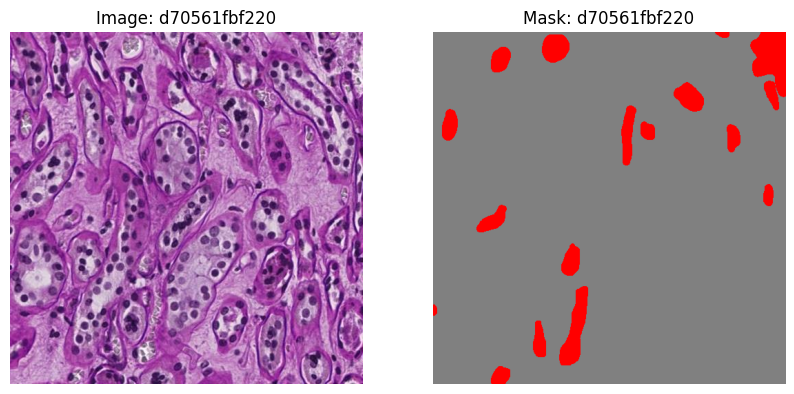

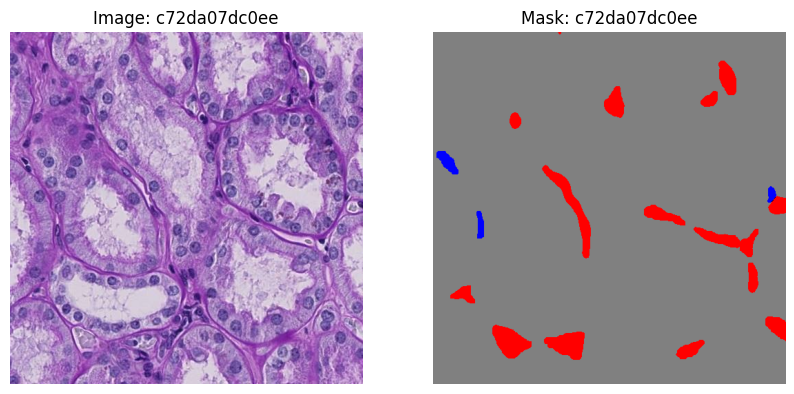

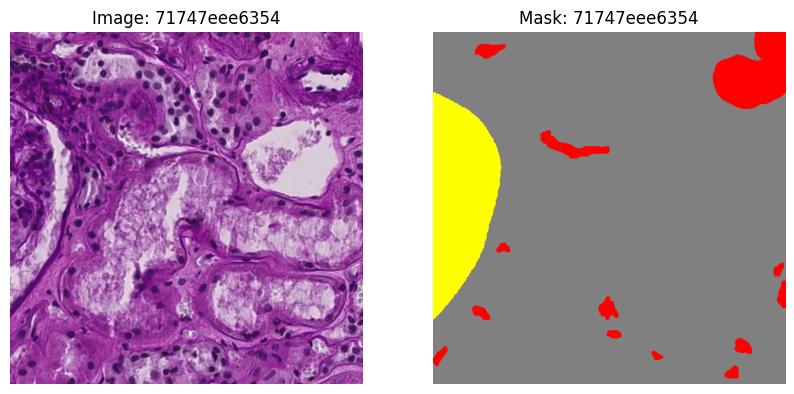

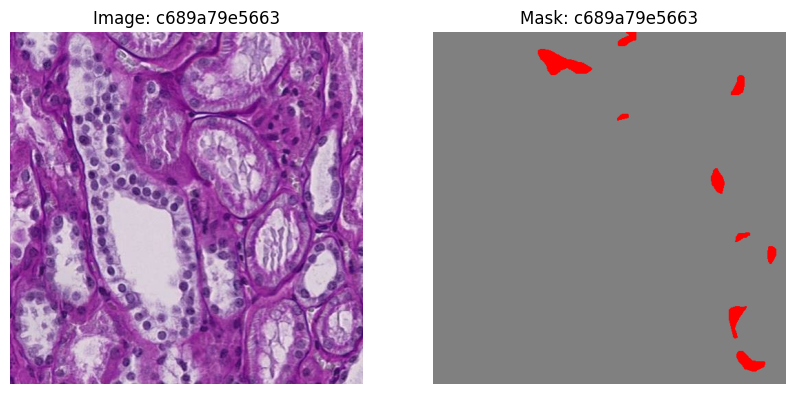

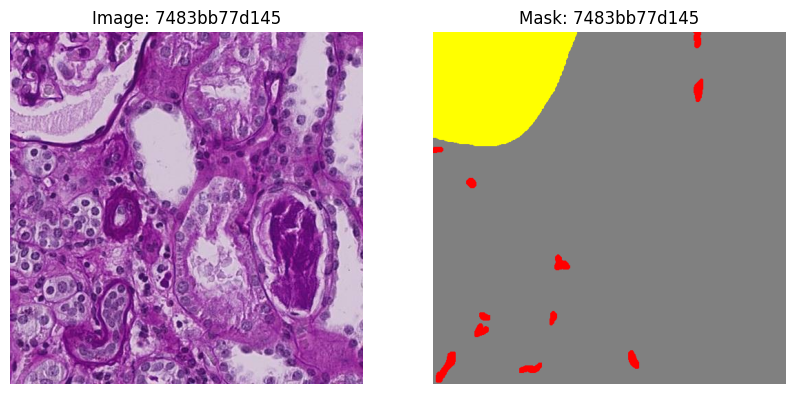

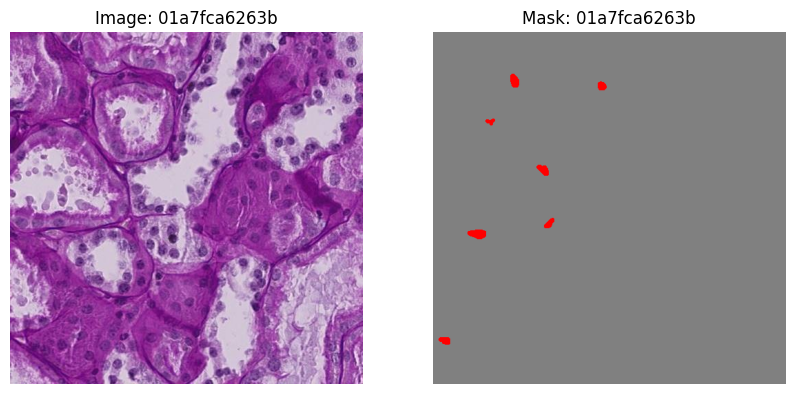

In [119]:
# Show images and masks
id_list = []
for i in range(6):
  idx_num = np.random.randint(len(mask_ids))

  id = mask_ids[idx_num]
  id_list.append(id)

  img_file_path = file_path + 'train/' + id + '.tif'
  y_file_path = mask_file_path + id +'_mask.tif'

  image = plt.imread(img_file_path)
  mask = plt.imread(y_file_path)

  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.imshow(image)
  plt.title('Image: '+id)
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(mask)
  plt.title('Mask: '+id)
  plt.axis('off')

if len(id_list) == 6:
  for id in id_list:
      blood_vessel_count = df.loc[id,'blood_vessel']
      glomerulus_count = df.loc[id,'glomerulus']
      unsure_count = df.loc[id,'unsure']
      print(f"id: {id}:: Blood Vessel count: {blood_vessel_count}\t Glomerulus count:\
            {glomerulus_count}\tUnsure count: {unsure_count}")

In [ ]:
id_list

['abe8e23f130b',
 '64a7e1b01c32',
 '1b0f943da76c',
 'cfcbc3b1aa48',
 '795b7a37fc4e',
 'c2569a219a0b']

id: a4ccac27ed46:: Blood Vessel count: 17	 Glomerulus count:   1	Unsure count: 0
id: e2c1ebfddb4a:: Blood Vessel count: 4	 Glomerulus count:   0	Unsure count: 1
id: 4b71f2e1d1ba:: Blood Vessel count: 20	 Glomerulus count:   0	Unsure count: 4
id: 2673eb939bf8:: Blood Vessel count: 12	 Glomerulus count:   0	Unsure count: 0
id: e6e180a81f0e:: Blood Vessel count: 10	 Glomerulus count:   0	Unsure count: 0
id: 0ce440ad7080:: Blood Vessel count: 12	 Glomerulus count:   1	Unsure count: 0


In [ ]:
mask = plt.imread('/gdrive/MyDrive/DATA/HuBMAP/masks/fce9ad75428d_mask.tif')

In [ ]:
df

blood_vessel  glomerulus  unsure
0006ff2aa7cd             8           1       0
00168d1b7522             1           1       0
0033bbc76b6b             3           0       1
003504460b3a             7           0       0
004daf1cbe75             9           1       0
...                    ...         ...     ...
ff434af74304            13           0       0
ff4897b3eda6            17           0       0
ff66dec71c4c            23           1       0
ff99cdef0f2a            11           1       0
ffd3d193c71e             5           2       0

[1633 rows x 3 columns]

In [ ]:
image_annotation_counts = {}

for mask_id in binary_masks.keys():
    annotation_counts = {}
    
    for idx,(annotation_type, mask) in enumerate(binary_masks[mask_id].items(),0):

        # Count the number of distinct areas in the mask
        labeled, num_areas = label(mask)
        annotation_counts[annotation_type] = num_areas
        image_annotation_counts[mask_id] = annotation_counts



In [ ]:
image_annotation_counts['0006ff2aa7cd']

{'blood_vessel': 8, 'glomerulus': 1, 'unsure': 0}

In [ ]:
df = pd.DataFrame(image_annotation_counts).transpose()

In [ ]:
!ls /gdrive/MyDrive/DATA/HuBMAP/

annotation_count.csv  polygons.jsonl	     test	    train
masks		      sample_submission.csv  tile_meta.csv  wsi_meta.csv


In [ ]:
df.to_csv('/gdrive/MyDrive/DATA/HuBMAP/annotation_count.csv')

In [ ]:
!ls /gdrive/MyDrive/DATA/HuBMAP/

masks		sample_submission.csv  tile_meta.csv  wsi_meta.csv
polygons.jsonl	test		       train


In [ ]:
binary_masks['']

'/gdrive/MyDrive/DATA/HuBMAP/'

In [ ]:
tile_meta = pd.read_csv(file_path+'sample_submission.csv')

In [ ]:
tile_meta.prediction_string

0    0 1.0 eNoLTDAwyrM3yI/PMwcAE94DZA==
Name: prediction_string, dtype: object

In [ ]:
# source: https://stackoverflow.com/questions/64681931/save-numpy-array-as-single-channel-png-with-custom-colors
#!/usr/bin/env python3

from PIL import Image
import numpy as np

# Make image with small random numbers
im = np.random.randint(0,5, (4,8), dtype=np.uint8)

# Make a palette
palette = [255,0,0,    # 0=red
           0,255,0,    # 1=green
           0,0,255,    # 2=blue
           255,255,0,  # 3=yellow
           0,255,255]  # 4=cyan
# Pad with zeroes to 768 values, i.e. 256 RGB colours
palette = palette + [0]*(768-len(palette))

# Convert Numpy array to palette image
pi = Image.fromarray(im,'P')

# Put the palette in
pi.putpalette(palette)

# Display and save
pi.show()
#pi.save('result.png')

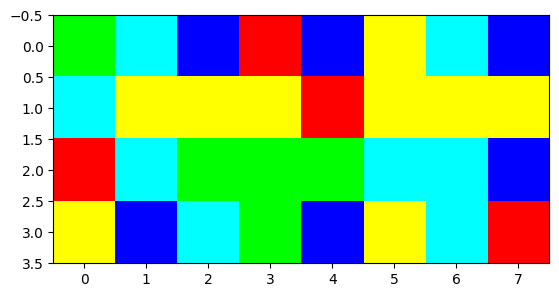

In [ ]:
plt.imshow(pi);

In [ ]:
im

array([[1, 4, 2, 0, 2, 3, 4, 2],
       [4, 3, 3, 3, 0, 3, 3, 3],
       [0, 4, 1, 1, 1, 4, 4, 2],
       [3, 2, 4, 1, 2, 3, 4, 0]], dtype=uint8)

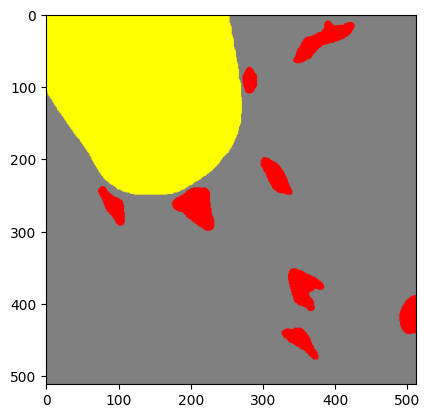

In [68]:
img = plt.imread('/gdrive/MyDrive/DATA/HuBMAP/temp_mask/0006ff2aa7cd_mask.tif')
plt.imshow(img)

In [60]:
merged_mask = binary_masks['0006ff2aa7cd']['blood_vessel'] + binary_masks['0006ff2aa7cd']['glomerulus'] \
          + binary_masks['0006ff2aa7cd']['unsure']

In [74]:
bv = binary_masks['0006ff2aa7cd']['blood_vessel']
g = binary_masks['0006ff2aa7cd']['glomerulus']
u = binary_masks['0006ff2aa7cd']['unsure'] 
bv[bv == 255] = 1
g[g==255] = 2
u[u==255] = 3
merged_mask = bv + g + u

In [80]:
merged_mask

array([[0, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [83]:
# Make a palette
palette = [128,128,128,     # 0=gray
            255,0,0,          # 1= red
            255,255,0,        # 2=yellow
            0,0,255]          # 3=blue
  
  # Pad with zeroes to 768 values, i.e. 256 RGB colours
palette = palette + [0]*(768-len(palette))

  # Convert Numpy array to palette image
mask_pi = Image.fromarray(merged_mask,'P')

  # Put the palette in
mask_pi.putpalette(palette)

mask_pi.save(file_path+'0006ff2aa7cd_mask.tif')

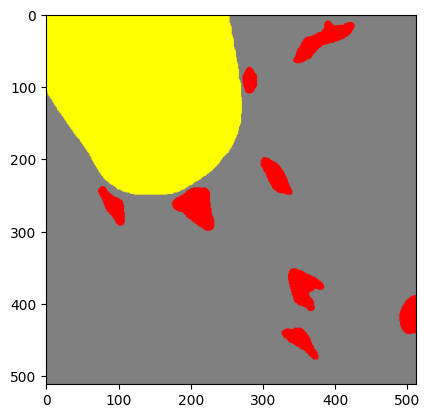

In [88]:
img = plt.imread(file_path+'0006ff2aa7cd_mask.tif')
plt.imshow(img)

In [89]:
img.shape

(512, 512, 4)